In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/netflow/CIDDS-001/traffic/mixed.csv', index_col='DATE')
df.drop(['FLAGS', 'CLASS', 'ATTACK_ID', 'ATTACK_DESCRIPTION'], axis=1, inplace=True)

df = df.sample(frac=1).iloc[:1000]

df['SRC'] = df['SRC_IP_ADDR'].str.cat(df['SRC_PORT'].astype(str), sep=':')
df['DST'] = df['DST_IP_ADDR'].str.cat(df['DST_PORT'].astype(str), sep=':')
df.drop(['SRC_IP_ADDR', 'SRC_PORT', 'DST_IP_ADDR', 'DST_PORT'], axis=1, inplace=True)
df.head()

DURATION PROTOCOL  PACKETS  BYTES  TOS ATTACK_TYPE  \
DATE                                                                          
2017-03-23 20:59:16.066     0.230    TCP          2  319.0    0      benign   
2017-03-23 07:00:50.795     0.000    TCP          1   66.0    0      benign   
2017-03-24 16:00:58.467     0.005    TCP          5  479.0    0         dos   
2017-03-27 15:05:23.201     0.015    TCP          3  624.0    0      benign   
2017-03-27 10:12:55.496     0.000    TCP          1   66.0    0      benign   

                             TYPE                   SRC               DST  
DATE                                                                       
2017-03-23 20:59:16.066  internal   192.168.200.9:54695   EXT_SERVER:8082  
2017-03-23 07:00:50.795  internal   192.168.220.9:41135     10431_220:443  
2017-03-24 16:00:58.467  internal  192.168.220.15:47274  192.168.100.6:80  
2017-03-27 15:05:23.201  internal  192.168.220.16:43207       10060_27:80  
2017-03-27 10:12:55.496  internal  192.168.220.13:36717       10499_46:80

In [3]:
from sklearn.preprocessing import LabelEncoder

def label_encode(series_to_encode):
    lb_e = LabelEncoder()
    return lb_e, lb_e.fit_transform(series_to_encode)

FEATURES_TO_LABELENCODE = ['PROTOCOL', 'TYPE', 'TOS', 'ATTACK_TYPE', 'SRC', 'DST']
encoders = {}

for f in FEATURES_TO_LABELENCODE:
    print("Processing feature {}".format(f))
    encoders[f], df[f] = label_encode(df[f])

Processing feature PROTOCOL
Processing feature TYPE
Processing feature TOS
Processing feature ATTACK_TYPE
Processing feature SRC
Processing feature DST


In [4]:
df['ATTACK_TYPE'].value_counts()

0    841
1    151
2      8
Name: ATTACK_TYPE, dtype: int64

In [5]:
pd.Series(encoders['ATTACK_TYPE'].inverse_transform(df['ATTACK_TYPE'])).value_counts()

benign      841
dos         151
portScan      8
dtype: int64

In [6]:
LABELS_COLORS_MAP = {
    0: "#299e50", 
    1: "#1900ff", 
    2: "#ff0000",
    3: "#fff700",
    4: "#1500ff"
}

COLORS_LABELS_MAP = {
    "#299e50": 0,
    "#1900ff": 1,
    "#ff0000": 2,
    "fff700": 3,
    "#1500ff": 4
}

LABELS_ENCODINGS_MAP = {
    0: "benign",
    1: "bruteForce",
    2: "dos",
    3: "pingScan",
    4: "portScan"
}

In [7]:
nodes_df = pd.concat([
    df[['SRC', 'TYPE']].rename(columns={'SRC': 'ID'}).reset_index(drop=True), 
    df[['DST', 'TYPE']].rename(columns={'DST': 'ID'}).reset_index(drop=True)
]).drop_duplicates()

nodes_df['COLOR'] = np.where(nodes_df['TYPE'] == 0, "#107be6", "#000000")
nodes_df.drop('TYPE', axis=1, inplace=True)

nodes_df.head()

ID    COLOR
0  288  #000000
1  700  #000000
2  511  #000000
3  600  #000000
4  352  #000000

In [8]:
edges_df = df[['SRC', 'DST', 'DURATION', 'PROTOCOL', 'PACKETS', 'BYTES', 'TOS', 'ATTACK_TYPE']]
edges_df['SPEED'] = edges_df['BYTES'] / edges_df['DURATION']
edges_df['SPEED'] = edges_df['SPEED'].replace([np.inf, -np.inf], 0.01)

edges_df.reset_index(inplace=True, drop=True)

edges_df.head()

SRC  DST  DURATION  PROTOCOL  PACKETS  BYTES  TOS  ATTACK_TYPE  \
0  288  736     0.230         1        2  319.0    0            0   
1  700  141     0.000         1        1   66.0    0            0   
2  511  282     0.005         1        5  479.0    0            1   
3  600   42     0.015         1        3  624.0    0            0   
4  352  151     0.000         1        1   66.0    0            0   

          SPEED  
0   1386.956522  
1      0.010000  
2  95800.000000  
3  41600.000000  
4      0.010000

In [9]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('notebooks'), '..'))

from graphs.multigraph import Multigraph
from embeddings.b_node2vec import Node2VecBaseline
from dim_reducers.b_tsne import tSNEBaseline

In [10]:
multigraph = Multigraph()

multigraph.add_nodes(nodes_df)
multigraph.add_edges(edges_df)

multigraph.plot()

# Test *1*
change HOPE parameters  
4 - 0.01

In [15]:
import matplotlib.pyplot as plt
from gem.embedding.hope import HOPE
from time import time

In [16]:
embedding = HOPE(d=4, beta=0.01)

print ('Num nodes: %d, num edges: %d' % (multigraph._G.number_of_nodes(), multigraph._G.number_of_edges()))
t1 = time()

# Learn embedding - accepts a networkx graph or file with edge list
Y, t = embedding.learn_embedding(graph=multigraph._G, edge_f=None, is_weighted=True, no_python=True)

print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

embd = embedding.get_embedding()

r = range(len(embd))
indexes = [i for i in r]

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embd)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in indexes]

Num nodes: 755, num edges: 4000
SVD error (low rank): 80.181154
hope_gsvd:
	Training time: 0.292217
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 755 samples in 0.001s...
[t-SNE] Computed neighbors for 755 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 755 / 755
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.207886
[t-SNE] KL divergence after 1000 iterations: 0.125607


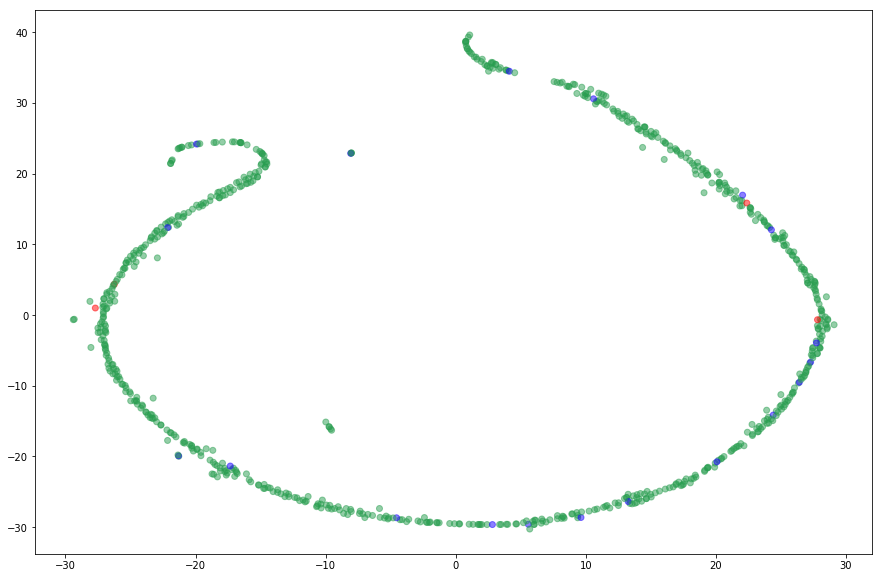

In [17]:
tsne.plot(colors)

# Test *2*
change HOPE parameters  
1000 - 0.01

In [18]:
embedding = HOPE(d=1000, beta=0.01)

print ('Num nodes: %d, num edges: %d' % (multigraph._G.number_of_nodes(), multigraph._G.number_of_edges()))
t1 = time()

# Learn embedding - accepts a networkx graph or file with edge list
Y, t = embedding.learn_embedding(graph=multigraph._G, edge_f=None, is_weighted=True, no_python=True)

print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

embd = embedding.get_embedding()

r = range(len(embd))
indexes = [i for i in r]

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embd)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in indexes]

Num nodes: 755, num edges: 4000
SVD error (low rank): 2.309679
hope_gsvd:
	Training time: 2.299443
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 755 samples in 0.001s...
[t-SNE] Computed neighbors for 755 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 755 / 755
[t-SNE] Mean sigma: 0.119002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.952637
[t-SNE] KL divergence after 1000 iterations: 1.161089


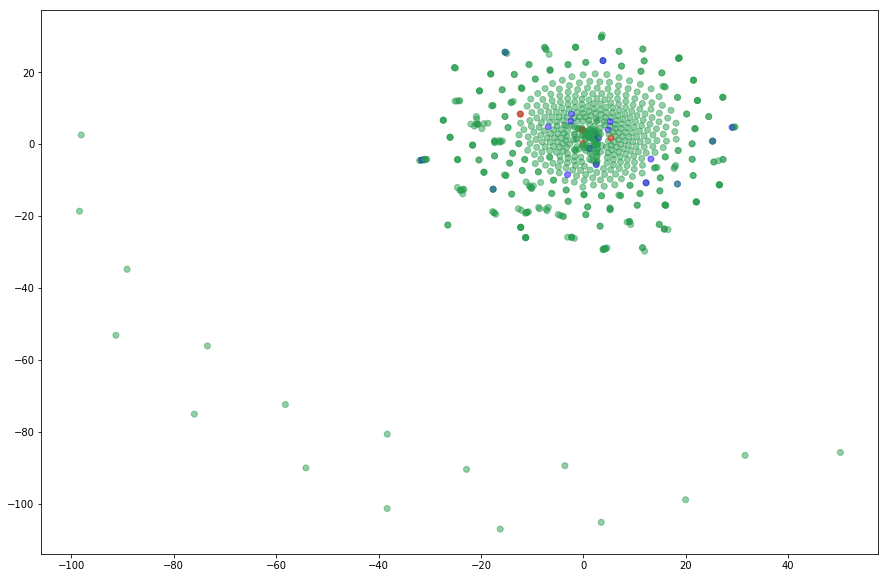

In [19]:
tsne.plot(colors)

# Test *3*
change HOPE parameters  
500 - 0.01

In [20]:
embedding = HOPE(d=500, beta=0.01)

print ('Num nodes: %d, num edges: %d' % (multigraph._G.number_of_nodes(), multigraph._G.number_of_edges()))
t1 = time()

# Learn embedding - accepts a networkx graph or file with edge list
Y, t = embedding.learn_embedding(graph=multigraph._G, edge_f=None, is_weighted=True, no_python=True)

print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

embd = embedding.get_embedding()

r = range(len(embd))
indexes = [i for i in r]

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embd)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in indexes]

Num nodes: 755, num edges: 4000
SVD error (low rank): 14.411953
hope_gsvd:
	Training time: 5.450070
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 755 samples in 0.000s...
[t-SNE] Computed neighbors for 755 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 755 / 755
[t-SNE] Mean sigma: 0.052429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.709686
[t-SNE] KL divergence after 1000 iterations: 1.024978


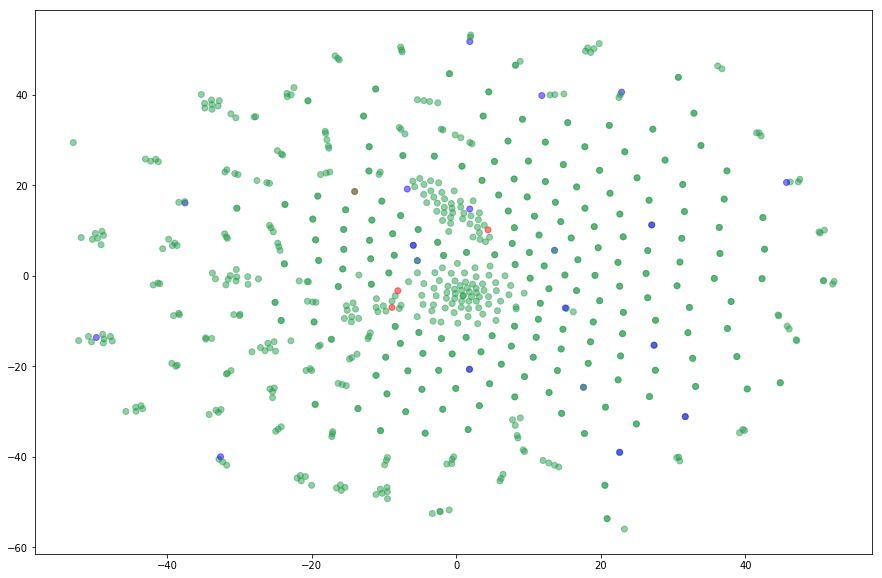

In [21]:
tsne.plot(colors)

# Test *4*
change HOPE parameters  
500 - 0.1

In [22]:
embedding = HOPE(d=500, beta=0.1)

print ('Num nodes: %d, num edges: %d' % (multigraph._G.number_of_nodes(), multigraph._G.number_of_edges()))
t1 = time()

# Learn embedding - accepts a networkx graph or file with edge list
Y, t = embedding.learn_embedding(graph=multigraph._G, edge_f=None, is_weighted=True, no_python=True)

print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

embd = embedding.get_embedding()

r = range(len(embd))
indexes = [i for i in r]

tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embd)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in indexes]

Num nodes: 755, num edges: 4000
SVD error (low rank): 16.705225
hope_gsvd:
	Training time: 22.954191
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 755 samples in 0.000s...
[t-SNE] Computed neighbors for 755 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 755 / 755
[t-SNE] Mean sigma: 0.011960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.717102
[t-SNE] KL divergence after 1000 iterations: 1.032339


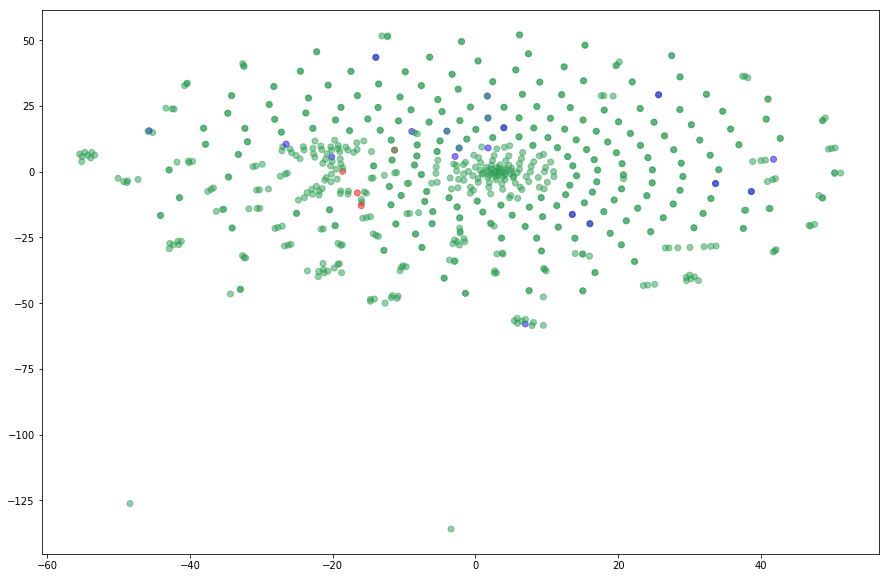

In [23]:
tsne.plot(colors)

# Test *tsne*
changement des parametres TSNE


In [25]:
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in indexes]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 755 samples in 0.000s...
[t-SNE] Computed neighbors for 755 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 755 / 755
[t-SNE] Mean sigma: 0.011960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.212051
[t-SNE] KL divergence after 1000 iterations: 1.036844


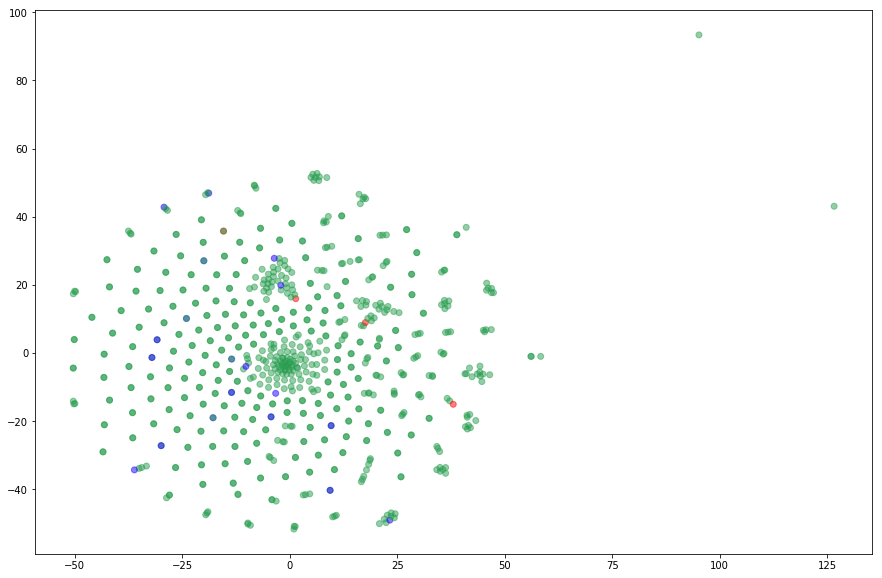

In [28]:
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embedding.get_embedding())

tsne.plot(colors)

# **Evaluation Score**

In [29]:
Xy = pd.DataFrame(tsne.reduced_vectors)
Xy['ID'] = indexes
Xy['LABEL'] = [COLORS_LABELS_MAP[l] for l in colors]
Xy.head()

0          1  ID  LABEL
0  -9.739526 -49.899738   0      0
1 -41.905090 -13.837276   1      0
2  20.847898   3.976731   2      0
3   8.413438   4.986414   3      0
4   7.980351  38.786068   4      0

In [30]:
X = Xy[[0, 1]]
y = Xy['LABEL']

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)

clf.fit(X_train, y_train)

/home/bkwg/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=10.



LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [33]:
from models import random, procedural1, procedural2, procedural3
from metrics import accuracy, confusion_matrix, recall

In [34]:
metrics = [accuracy, recall, confusion_matrix]

	 Accuracy Score: 0.9801324503311258
	 Recall: 0.9801324503311258
	 Confusion Matrix:


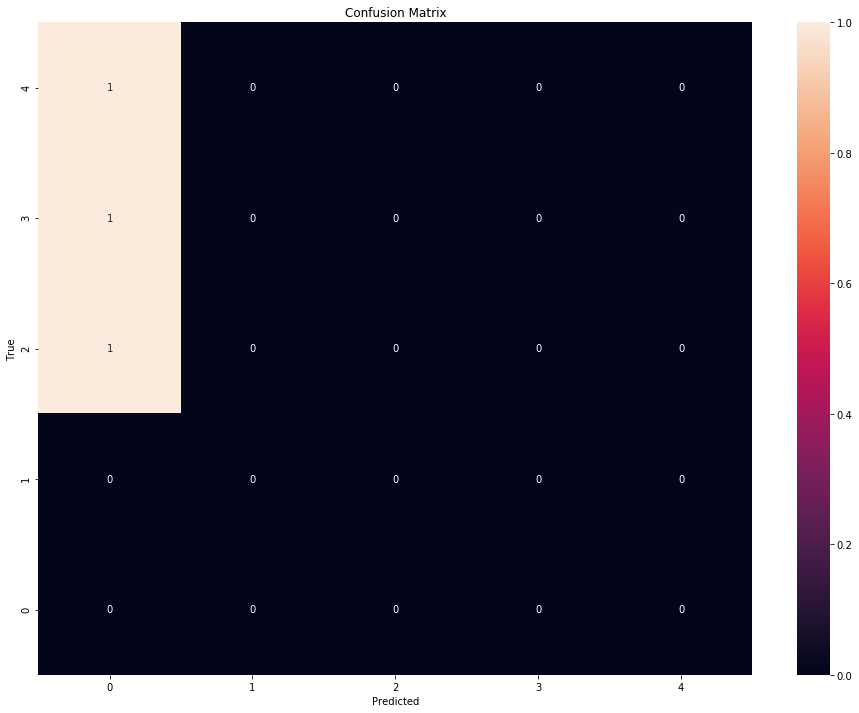

In [35]:
for metric in metrics:
        metric_name = metric.name
    
        if metric_name == 'Confusion Matrix':
            print("\t {}:".format(metric_name))
            _ = metric.plot(Y_true=y_test, 
                            Y_predicted=clf.predict(X_test), 
                            labels=[0, 1, 2, 3, 4]
                           )
        else:
            print("\t {}: {}".format(metric_name, metric.evaluate(Y_true=y_test, Y_predicted=clf.predict(X_test))))